<a href="https://colab.research.google.com/github/MPGarg/Session-4/blob/main/EVA8S4E2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Attempt 2:**

Target:
*   Lower number of parameters (Near to our target of <=10000 Parameters)
*   Batch-norm to increase model efficiency
*   DropOut to avoid overfitting
*   Add GAP Layer and remove last big kernel

Results:
*   Total Parameters: 12,862
*   Best Training Accuracy: 98.89%
*   Best Test Accuracy: 99.01%

Analysis:
*   Model learned well and can do better if pushed to more epochs. But with current capacity it is not possible to push further.
*   Introducing Batch Normalization has helped the model in learning even with reduced parameters.
*   DropOut made the model resilient and we got Testing accuracy better than Training accuracy. 
*   GAP layer has not reduced accuracy (size of 8 is used in model)
*   More regularization techniques are needed to make this work with even fewer parameters and have to achieve higher test accuracy!

# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Transformations

*   Image Normalization


In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std  
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
#Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create.
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


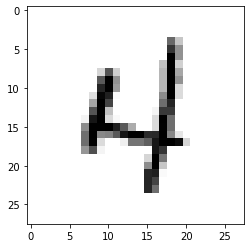

In [ ]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## More Images

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

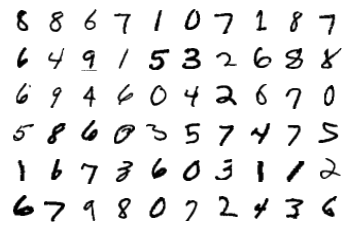

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model

Basic working model with Train & Test Validations

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU()
        ) # output_size = 26 RF = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU()
        ) # output_size = 24 RF = 5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12 RF = 6

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU()
        ) # output_size = 12 RF = 6

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU()
        ) # output_size = 10 RF = 10

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU()
        ) # output_size = 8 RF = 14

        # OUTPUT BLOCK
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 8 RF = 14

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=8)
        ) # output_size = 1 RF = 28

        self.dropout = nn.Dropout(0.05)

    def forward(self, x):
        x = self.dropout(self.convblock1(x))
        x = self.dropout(self.convblock2(x))
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.dropout(self.convblock4(x))
        x = self.dropout(self.convblock5(x))
        x = self.convblock6(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [ ]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
       BatchNorm2d-2           [-1, 16, 26, 26]              32
              ReLU-3           [-1, 16, 26, 26]               0
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 32, 24, 24]           4,640
       BatchNorm2d-6           [-1, 32, 24, 24]              64
              ReLU-7           [-1, 32, 24, 24]               0
           Dropout-8           [-1, 32, 24, 24]               0
         MaxPool2d-9           [-1, 32, 12, 12]               0
           Conv2d-10           [-1, 16, 12, 12]             528
      BatchNorm2d-11           [-1, 16, 12, 12]              32
             ReLU-12           [-1, 16, 12, 12]               0
           Conv2d-13           [-1, 16, 10, 10]           2,320
      BatchNorm2d-14           [-1

# Training and Testing

We have 12.8k params for this model

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    
    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)
    
    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Train and Test of our model

In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch + 1 )
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 1


Loss=0.2529955208301544 Batch_id=468 Accuracy=84.29: 100%|██████████| 469/469 [00:14<00:00, 33.13it/s]



Test set: Average loss: 0.3078, Accuracy: 9585/10000 (95.85%)

EPOCH: 2


Loss=0.21097217500209808 Batch_id=468 Accuracy=96.37: 100%|██████████| 469/469 [00:15<00:00, 29.63it/s]



Test set: Average loss: 0.1761, Accuracy: 9681/10000 (96.81%)

EPOCH: 3


Loss=0.13285139203071594 Batch_id=468 Accuracy=97.36: 100%|██████████| 469/469 [00:15<00:00, 29.96it/s]



Test set: Average loss: 0.1081, Accuracy: 9812/10000 (98.12%)

EPOCH: 4


Loss=0.1568455547094345 Batch_id=468 Accuracy=97.89: 100%|██████████| 469/469 [00:14<00:00, 33.31it/s]



Test set: Average loss: 0.1213, Accuracy: 9755/10000 (97.55%)

EPOCH: 5


Loss=0.09349501878023148 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:14<00:00, 31.29it/s]



Test set: Average loss: 0.0877, Accuracy: 9822/10000 (98.22%)

EPOCH: 6


Loss=0.07659097760915756 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:20<00:00, 23.28it/s]



Test set: Average loss: 0.0888, Accuracy: 9799/10000 (97.99%)

EPOCH: 7


Loss=0.09701508283615112 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:14<00:00, 33.25it/s]



Test set: Average loss: 0.0611, Accuracy: 9867/10000 (98.67%)

EPOCH: 8


Loss=0.06841578334569931 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:14<00:00, 33.04it/s]



Test set: Average loss: 0.0593, Accuracy: 9867/10000 (98.67%)

EPOCH: 9


Loss=0.05251335725188255 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:14<00:00, 33.25it/s]



Test set: Average loss: 0.0554, Accuracy: 9873/10000 (98.73%)

EPOCH: 10


Loss=0.07996686547994614 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:14<00:00, 33.28it/s]



Test set: Average loss: 0.0555, Accuracy: 9870/10000 (98.70%)

EPOCH: 11


Loss=0.02397572249174118 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:14<00:00, 32.78it/s]



Test set: Average loss: 0.0486, Accuracy: 9891/10000 (98.91%)

EPOCH: 12


Loss=0.06873343139886856 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:14<00:00, 32.88it/s]



Test set: Average loss: 0.0478, Accuracy: 9894/10000 (98.94%)

EPOCH: 13


Loss=0.058035075664520264 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:15<00:00, 29.50it/s]



Test set: Average loss: 0.0434, Accuracy: 9891/10000 (98.91%)

EPOCH: 14


Loss=0.03639918565750122 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:20<00:00, 22.51it/s]



Test set: Average loss: 0.0409, Accuracy: 9901/10000 (99.01%)

EPOCH: 15


Loss=0.0494968481361866 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:14<00:00, 33.03it/s]



Test set: Average loss: 0.0435, Accuracy: 9893/10000 (98.93%)



In [ ]:
train_losses1 = [t.cpu().item() for t in train_losses]

Text(0.5, 1.0, 'Test Accuracy')

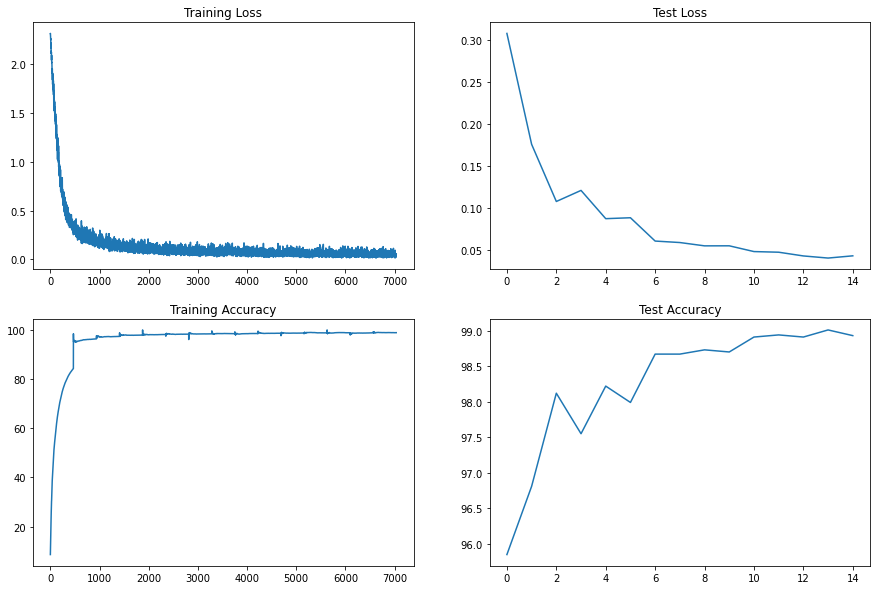

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses1)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")